In [42]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from data_cleanup import *
from feature_selection import *
from model_ import *

from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as rmse
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LassoLarsCV
from sklearn.ensemble import RandomForestRegressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
corr_cols = ['ti_cpi', 'bci_bci', 'ti_cpi_om', 'vdem_corr', 'vdem_execorr', 'vdem_jucorrdc', 'vdem_pubcorr', 'wbgi_cce']
corr_cols = ['ti_cpi', 'bci_bci', 'ti_cpi_om', 'wbgi_cce']
meta_cols = ['ccode', 'ccode_qog', 'ccodealp', 'ccodealp_year', 'ccodecow', 'cname', 'cname_qog', 'cname_year', 'version', 'year', 'region', 'sub-region']
df = load_reduced_df(corr_cols)

### Feature selection

In [44]:
df = drop_date_columns(df)

best_features_dict = {}
selected_features_dict = {}
l = ['vdem', 'wbgi', 'ti']
l = ['wbgi', 'ti']

vdem_cor = (['vdem_corr', 'vdem_execorr', 'vdem_jucorrdc', 'vdem_pubcorr', 
    'bci_bcistd', 
    'vdem_exbribe', 'vdem_excrptps', 'vdem_exembez', 'vdem_exthftps', 'vdem_mecorrpt', 
    'wbgi_ccs', 'wbgi_rle', 'wbgi_rln', 'wbgi_rls'])

df = df.drop(columns=vdem_cor)

# df = df[[c for c in df.columns if (
#     (c.split('_')[0] not in l) or
#     (c in corr_cols) or 
#     (c in meta_cols))
#     ]].copy()

#print(df.columns.difference(clist))

df.loc[df['sub-region']=='Melanesia', 'sub-region'] = 'Pacific Islands'
df.loc[df['sub-region']=='Micronesia', 'sub-region'] = 'Pacific Islands'
df.loc[df['sub-region']=='Polynesia', 'sub-region'] = 'Pacific Islands'
#print(df.groupby(['region', 'sub-region']).cname.nunique())

for target_col in corr_cols:
    #l = ['vdem', 'wbgi', 'ti']
    l = ['wbgi', 'ti']

    clist = []

    for c in df.columns:
        if c in meta_cols+corr_cols:
            clist.append(c)
        elif c.split('_')[0] not in l:
            clist.append(c)

    df_red = df[clist].copy()

    X_train, X_test, y_train, y_test = create_traintestsplit(df_red, corr_cols = corr_cols, meta_cols=meta_cols, target_col=target_col)
    best_features = pre_select(X_train, y_train)
    best_features = filter_corruption(best_features)
    best_features_dict[target_col] = set(best_features)
    
    df_train = X_train.copy()
    df_train[target_col]=y_train
    mce = MultiCollinearityEliminator(df_train, target_col, 0.85)
    feaures_no_collinearity = list(mce.autoEliminateMulticollinearity().columns)
    feaures_no_collinearity.remove(target_col)
    selected_features_dict[target_col] = set(feaures_no_collinearity)

#selected_features_dict

In [45]:
best_features_union=list(set.union(*list(best_features_dict.values())))
best_features_intersection=list(set.intersection(*list(best_features_dict.values())))

best_features_intersection

['ihme_lifexp_0104m',
 'fh_status',
 'ihme_lifexp_0104f',
 'bmr_demdur',
 'fh_cl',
 'ihme_hle_0104f',
 'bmr_demfsuf',
 'br_mon',
 'br_dem',
 'ihme_lifexp_0104t',
 'ihme_hle_0104t',
 'fh_ipolity2',
 'ihme_hle_0104m',
 'ht_colonial',
 'br_pres',
 'br_elect',
 'bmr_dem',
 'fh_pr']

In [46]:
selected_features_union=list(set.union(*list(selected_features_dict.values())))
selected_features_intersection=list(set.intersection(*list(selected_features_dict.values())))

selected_features_intersection

['br_elecyear',
 'br_regch',
 'bmr_dembr',
 'fh_cl',
 'bmr_demdur',
 'ht_region',
 'br_mon',
 'nrmi_nrpi',
 'br_suff',
 'br_coup',
 'br_newconst',
 'bmr_demtran',
 'br_scoup',
 'ht_colonial',
 'br_pres',
 'br_elect',
 'br_cw',
 'br_com']

## Modeling

Try Lasso and Random Forest next. Train models for different feature configurations 

    - individual selected features for a particular index
    - union of all good features for all indices
    - intersection of all selected for features for all indices

As scores r2 and rmse are reported. The comparisons are based on r2-scores as they make the scores for different indices comparable.
    

### Lasso
The used library uses cross validation to determine a good value for alpha.

The following script trains for all target indices a Lasso model, then displays r2 score and feature importance information. 

In [47]:
def lasso_info_script(features):
    lasso_bf = dict()

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            lasso_bf[target] = apply_lassocv(df, target, list(features[target]), corr_cols, meta_cols, fprint=False)
        else:
            lasso_bf[target] = apply_lassocv(df, target, features, corr_cols, meta_cols, fprint=False)
        df_score.loc[target,] = [lasso_bf[target]['r2'] ,lasso_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    l_fi = [lasso_bf[target]['feat_importance'] for target in corr_cols]
    df_fi = pd.concat(l_fi)

    l_firk = [lasso_bf[target]['feat_importance_rank'] for target in corr_cols]
    df_firk = pd.concat(l_firk)

    print('feature importance')
    display(df_fi)
    df_fi.T.plot(kind='bar', figsize=(20,8))
    print()

    print('feature importance rank')
    display(df_firk)
    print()


First we apply the script for the individually selected features for each corruption index.

scores


,r2,rmse
ti_cpi,0.634065,9.523974
bci_bci,0.316709,10.839491
ti_cpi_om,0.443855,1.294621
wbgi_cce,0.55483,0.560222


feature importance


,ht_region,br_suff,br_coup,bmr_demtran,br_scoup,br_pres,br_cw,bmr_dembr,bmr_demdur,nrmi_nrpi,...,fh_cl,br_mon,br_dem,br_com,br_regch,br_newconst,ihme_lifexp_0104t,br_elect,ihme_lifexp_0104m,br_fcoup
ti_cpi,0.0,0.071,0.0,0.0,0.0,0.0,0.0,0.0,0.084169,0.0,...,0.437685,0.201178,0.0,0.0,0.0,0.0,0.201008,0.004959,NaN,NaN
bci_bci,0.006841,0.0302,0.002249,0.0,0.004282,0.0,0.02856,0.020007,0.107943,0.017259,...,0.275846,0.188731,NaN,0.011466,0.0,0.0,NaN,0.071623,0.213896,0.0
ti_cpi_om,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011516,0.140076,0.0,...,0.379363,0.188266,NaN,0.0,0.0,0.0,NaN,0.056049,0.203851,0.0
wbgi_cce,0.0,0.030878,0.0,0.0,0.0,0.0,0.01025,0.0,0.103062,0.0,...,0.42692,0.171859,NaN,0.0,0.0,0.0,0.1932,0.063831,NaN,0.0



feature importance rank


,ht_region,br_suff,br_coup,bmr_demtran,br_scoup,br_pres,br_cw,bmr_dembr,bmr_demdur,nrmi_nrpi,...,fh_cl,br_mon,br_dem,br_com,br_regch,br_newconst,ihme_lifexp_0104t,br_elect,ihme_lifexp_0104m,br_fcoup
ti_cpi,<NA>,5,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,4,<NA>,...,1,2,<NA>,<NA>,<NA>,<NA>,3,6,<NA>,<NA>
bci_bci,12,6,14,<NA>,13,<NA>,7,9,4,10,...,1,3,<NA>,11,<NA>,<NA>,<NA>,5,2,<NA>
ti_cpi_om,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,7,4,<NA>,...,1,3,<NA>,<NA>,<NA>,<NA>,<NA>,5,2,<NA>
wbgi_cce,<NA>,6,<NA>,<NA>,<NA>,<NA>,7,<NA>,4,<NA>,...,1,3,<NA>,<NA>,<NA>,<NA>,2,5,<NA>,<NA>


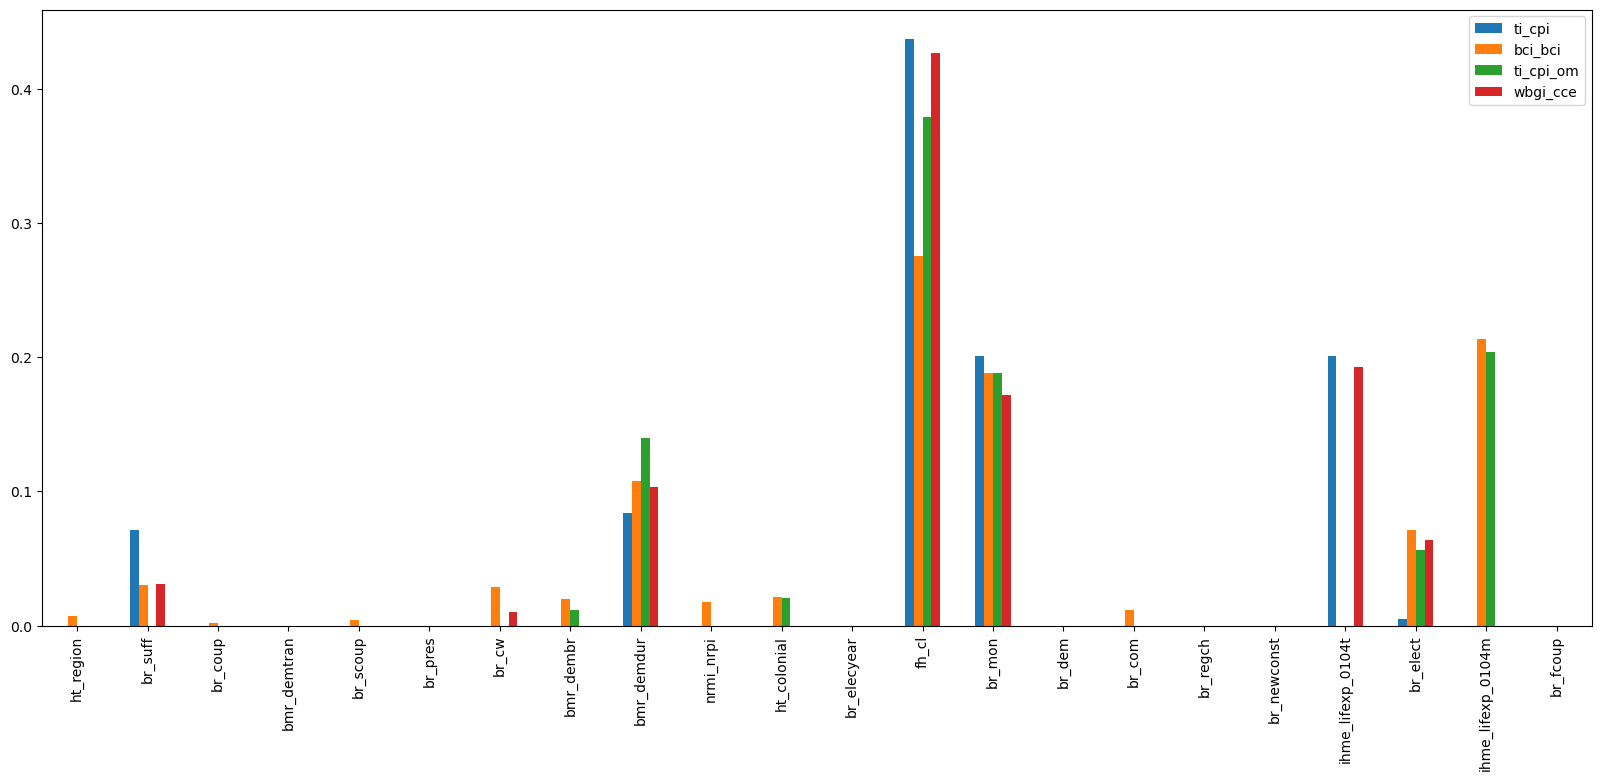

In [48]:
lasso_info_script(selected_features_dict)

Next we use for all corruption indices the same set of features - the set of all as promising declared features.

scores


,r2,rmse
ti_cpi,0.61553,9.762193
bci_bci,0.331835,10.718842
ti_cpi_om,0.447623,1.290229
wbgi_cce,0.536961,0.571355


feature importance


,ihme_lifexp_0104m,ht_region,br_suff,ihme_hle_0104t,br_pres,br_cw,bmr_demdur,bmr_demfsuf,nrmi_nrpi,ihme_hle_0104m,...,fh_cl,fh_status,ihme_lifexp_0104f,br_mon,br_dem,fh_ipolity2,fh_pr,ihme_hle_0104f,ihme_lifexp_0104t,br_elect
ti_cpi,0.202462,0.0,0.069411,0.0,0.0,0.00014,0.077447,0.0,0.0,0.0,...,0.446943,0.0,0.0,0.193942,0.0,0.0,0.0,0.0,0.0,0.009656
bci_bci,0.02573,0.013544,0.013764,0.0,0.007517,0.01589,0.029241,0.032815,0.017828,0.0,...,0.192475,0.09229,0.0,0.071962,0.010279,0.115403,0.153713,0.057769,0.107745,0.020556
ti_cpi_om,0.205207,0.0,0.0,0.0,0.0,0.0,0.141989,0.0,0.0,0.0,...,0.381559,0.0,0.0,0.18949,0.023064,0.0,0.0,0.0,0.0,0.037579
wbgi_cce,0.177528,0.0,0.028433,0.0,0.0,0.005323,0.097934,0.0,0.0,0.0,...,0.438429,0.0,0.0,0.173327,0.0,0.0,0.0,0.0,0.019943,0.056417



feature importance rank


,ihme_lifexp_0104m,ht_region,br_suff,ihme_hle_0104t,br_pres,br_cw,bmr_demdur,bmr_demfsuf,nrmi_nrpi,ihme_hle_0104m,...,fh_cl,fh_status,ihme_lifexp_0104f,br_mon,br_dem,fh_ipolity2,fh_pr,ihme_hle_0104f,ihme_lifexp_0104t,br_elect
ti_cpi,2,<NA>,5,<NA>,<NA>,7,4,<NA>,<NA>,<NA>,...,1,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,6
bci_bci,10,16,15,<NA>,18,14,9,8,13,<NA>,...,1,5,<NA>,6,17,3,2,7,4,12
ti_cpi_om,2,<NA>,<NA>,<NA>,<NA>,<NA>,4,<NA>,<NA>,<NA>,...,1,<NA>,<NA>,3,6,<NA>,<NA>,<NA>,<NA>,5
wbgi_cce,2,<NA>,6,<NA>,<NA>,8,4,<NA>,<NA>,<NA>,...,1,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,7,5


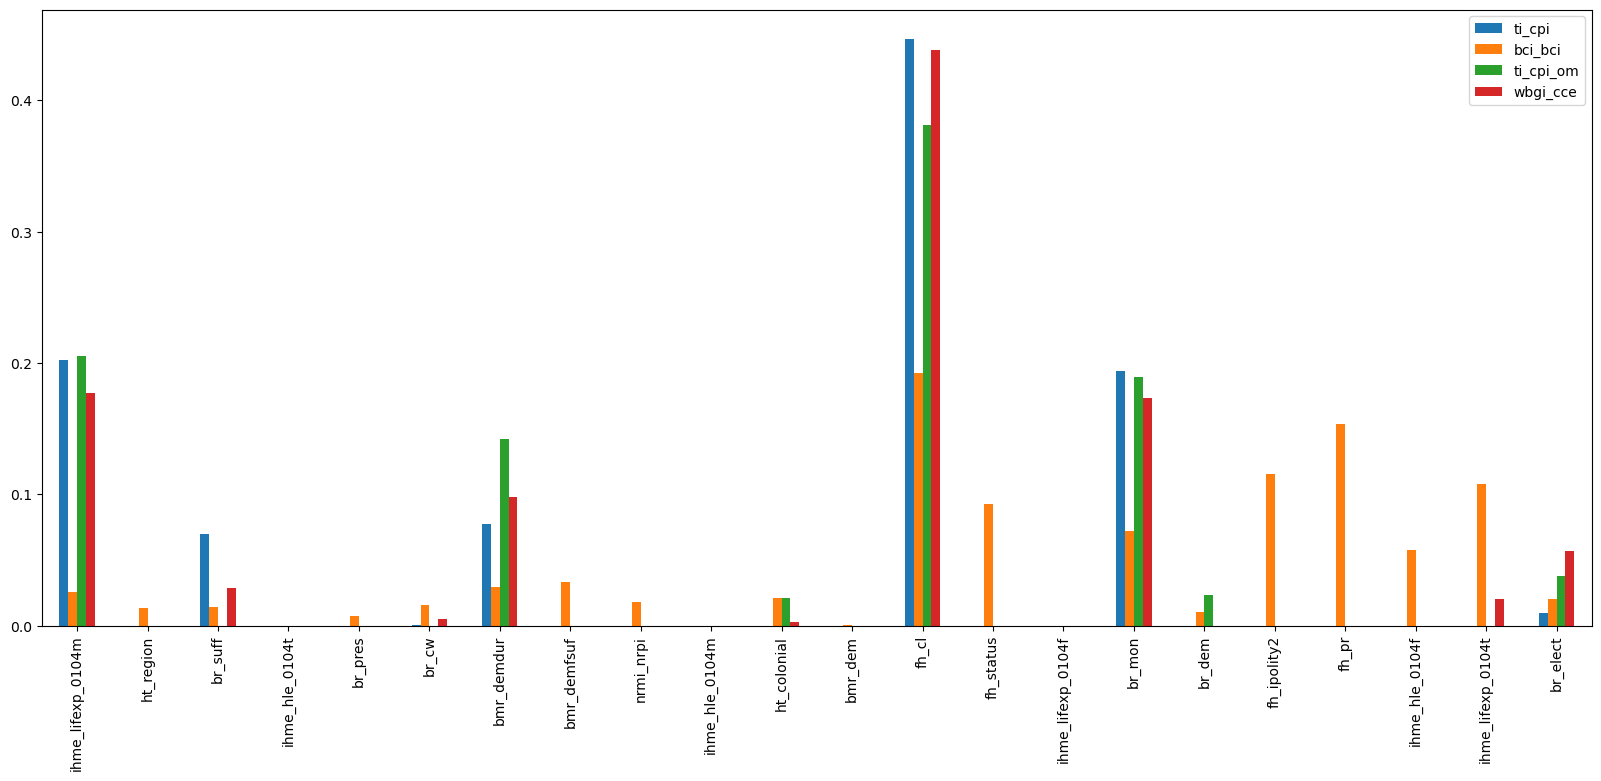

In [49]:
lasso_info_script(best_features_union)

Now we use only the features that are in all individually selected feature sets.

scores


,r2,rmse
ti_cpi,0.652223,9.284665
bci_bci,0.409868,10.073503
ti_cpi_om,0.539689,1.177808
wbgi_cce,0.619898,0.517664


feature importance


,br_elecyear,br_regch,bmr_dembr,fh_cl,bmr_demdur,ht_region,br_mon,nrmi_nrpi,br_suff,br_coup,br_newconst,bmr_demtran,br_scoup,ht_colonial,br_pres,br_elect,br_cw,br_com
ti_cpi,0.0,0.0,0.0,0.526759,0.113934,0.0,0.210397,0.0,0.077473,0.0,0.0,0.0,0.0,0.053502,0.0,0.017934,0.0,0.0
bci_bci,0.0,0.0,0.0,0.370492,0.186936,0.010574,0.253303,0.015852,0.049689,0.0,0.0,0.0,0.0,0.073176,0.014529,0.025449,0.0,0.0
ti_cpi_om,0.0,0.0,0.0,0.447965,0.206272,0.0,0.226519,0.0,0.001711,0.0,0.0,0.0,0.0,0.082131,0.017461,0.01794,0.0,0.0
wbgi_cce,0.0,0.0,0.0,0.496033,0.136308,0.0,0.180817,0.0,0.043598,0.002739,0.0,0.0,0.0,0.059474,0.015843,0.060213,0.0,0.004974



feature importance rank


,br_elecyear,br_regch,bmr_dembr,fh_cl,bmr_demdur,ht_region,br_mon,nrmi_nrpi,br_suff,br_coup,br_newconst,bmr_demtran,br_scoup,ht_colonial,br_pres,br_elect,br_cw,br_com
ti_cpi,<NA>,<NA>,<NA>,1,3,<NA>,2,<NA>,4,<NA>,<NA>,<NA>,<NA>,5,<NA>,6,<NA>,<NA>
bci_bci,<NA>,<NA>,<NA>,1,3,9,2,7,5,<NA>,<NA>,<NA>,<NA>,4,8,6,<NA>,<NA>
ti_cpi_om,<NA>,<NA>,<NA>,1,3,<NA>,2,<NA>,7,<NA>,<NA>,<NA>,<NA>,4,6,5,<NA>,<NA>
wbgi_cce,<NA>,<NA>,<NA>,1,3,<NA>,2,<NA>,6,9,<NA>,<NA>,<NA>,5,7,4,<NA>,8


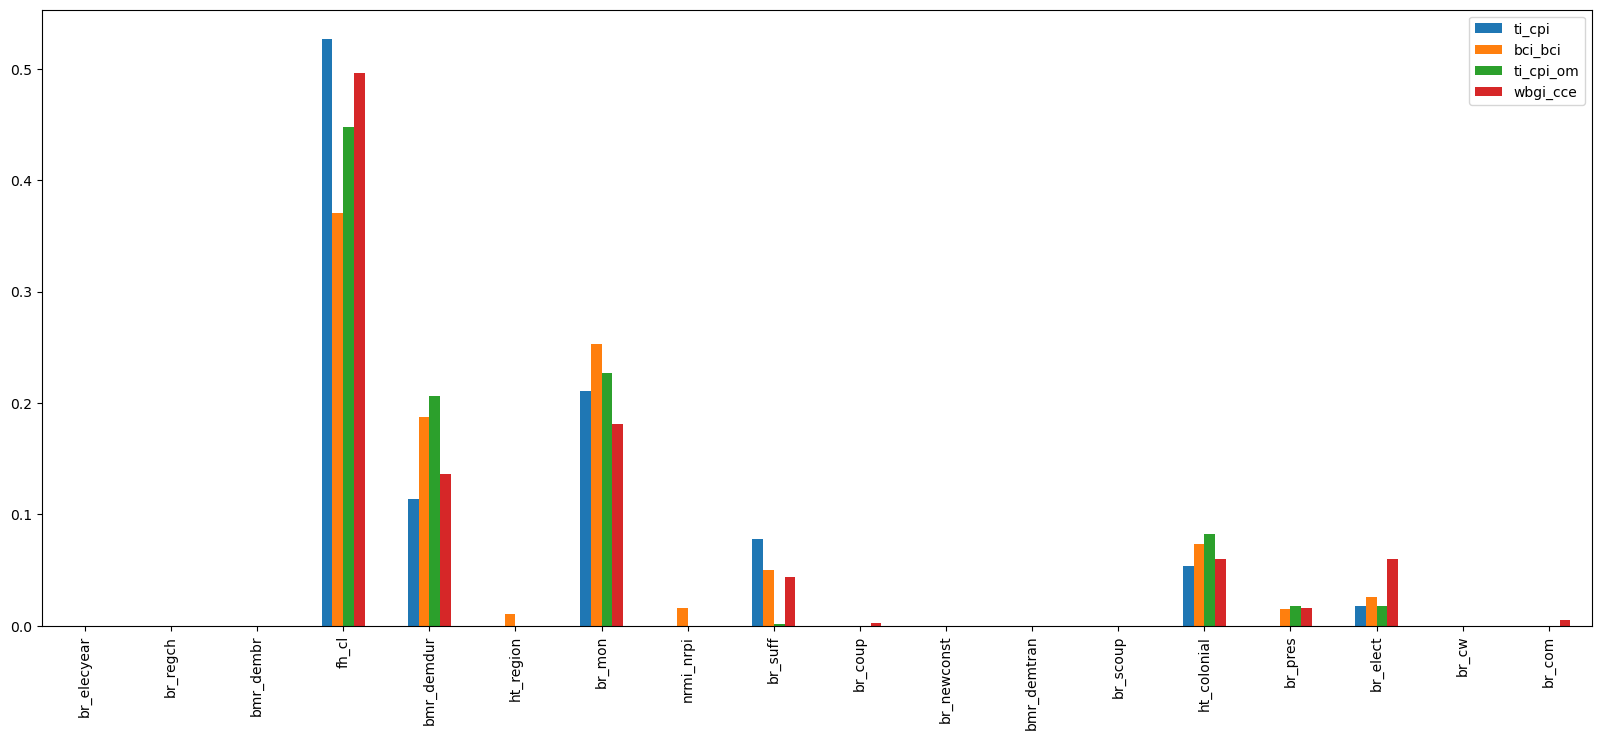

In [50]:
lasso_info_script(selected_features_intersection)

Findings:

- wbgi_rle (Rule of Law) is by far the most important feature in almost all configurations
- most indices behave similarly for the three feature set configuration but
- ti_cpi is most different: its score is very bad with the smallest feature set. Its most important feature is wbgi_pvs [Political Stability and Absence of Violence/Terrorism, Standard error] and not wbgi_rle
- vdem_jucorrdc is also effected more by different feature sets and its score is lower as well in general.
- all the other indices gain information slightly by more features but they do not rely too much on the chosen setups

### Random Forest

Next we do the same for a Random Forest Regressor. Here initially no cross validation is done. We just use a default setup at first.

In [51]:
def rf_info_script(features):
    rf_bf = dict()

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            rf_bf[target] = apply_rf(df, target, list(features[target]), corr_cols, meta_cols, fprint=False)
        else:
            rf_bf[target] = apply_rf(df, target, features, corr_cols, meta_cols, fprint=False)
        df_score.loc[target,] = [rf_bf[target]['r2'] ,rf_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    l_fi = [rf_bf[target]['feat_importance'] for target in corr_cols]
    df_fi = pd.concat(l_fi)

    l_firk = [rf_bf[target]['feat_importance_rank'] for target in corr_cols]
    df_firk = pd.concat(l_firk)

    print('feature importance')
    display(df_fi)

    df_fi.T.plot(kind='bar', figsize=(20,8))
    print()

    print('feature importance rank')
    display(df_firk)
    print()



First we apply again the script for the individually selected features for each corruption index.

scores


,r2,rmse
ti_cpi,0.678713,8.924057
bci_bci,0.415203,10.027869
ti_cpi_om,0.537542,1.180551
wbgi_cce,0.541977,0.568252


feature importance


,ht_region,br_suff,br_coup,bmr_demtran,br_scoup,br_pres,br_cw,bmr_dembr,bmr_demdur,nrmi_nrpi,...,fh_cl,br_mon,br_dem,br_com,br_regch,br_newconst,ihme_lifexp_0104t,br_elect,ihme_lifexp_0104m,br_fcoup
ti_cpi,0.008662,0.00863,0.000126,0.000152,0.000202,0.01341,0.010006,0.008517,0.071058,0.03155,...,0.631574,0.03461,0.001423,0.000474,0.0,0.000131,0.157351,0.006708,NaN,NaN
bci_bci,0.043006,0.000692,0.000062,0.000109,0.00002,0.033494,0.010443,0.02174,0.103175,0.069698,...,0.460286,0.06606,NaN,0.00159,0.000051,0.000084,NaN,0.011111,0.144771,0.000069
ti_cpi_om,0.028446,0.000951,0.000046,0.000034,0.000013,0.039904,0.008547,0.013463,0.107345,0.028827,...,0.582277,0.02335,NaN,0.000259,0.000054,0.000173,NaN,0.003745,0.154784,0.00002
wbgi_cce,0.019638,0.003127,0.000082,0.000066,0.000026,0.025347,0.013246,0.00977,0.079271,0.032923,...,0.605368,0.040241,NaN,0.001159,0.00002,0.000148,0.140996,0.008908,NaN,0.000051



feature importance rank


,ht_region,br_suff,br_coup,bmr_demtran,br_scoup,br_pres,br_cw,bmr_dembr,bmr_demdur,nrmi_nrpi,...,fh_cl,br_mon,br_dem,br_com,br_regch,br_newconst,ihme_lifexp_0104t,br_elect,ihme_lifexp_0104m,br_fcoup
ti_cpi,9,10,19,17,16,7,8,11,3,5,...,1,4,13,15,<NA>,18,2,12,<NA>,<NA>
bci_bci,6,13,18,15,20,7,11,9,3,4,...,1,5,<NA>,12,19,16,<NA>,10,2,17
ti_cpi_om,6,13,17,18,20,4,9,8,3,5,...,1,7,<NA>,14,16,15,<NA>,11,2,19
wbgi_cce,7,12,16,17,19,6,9,10,3,5,...,1,4,<NA>,13,20,15,2,11,<NA>,18


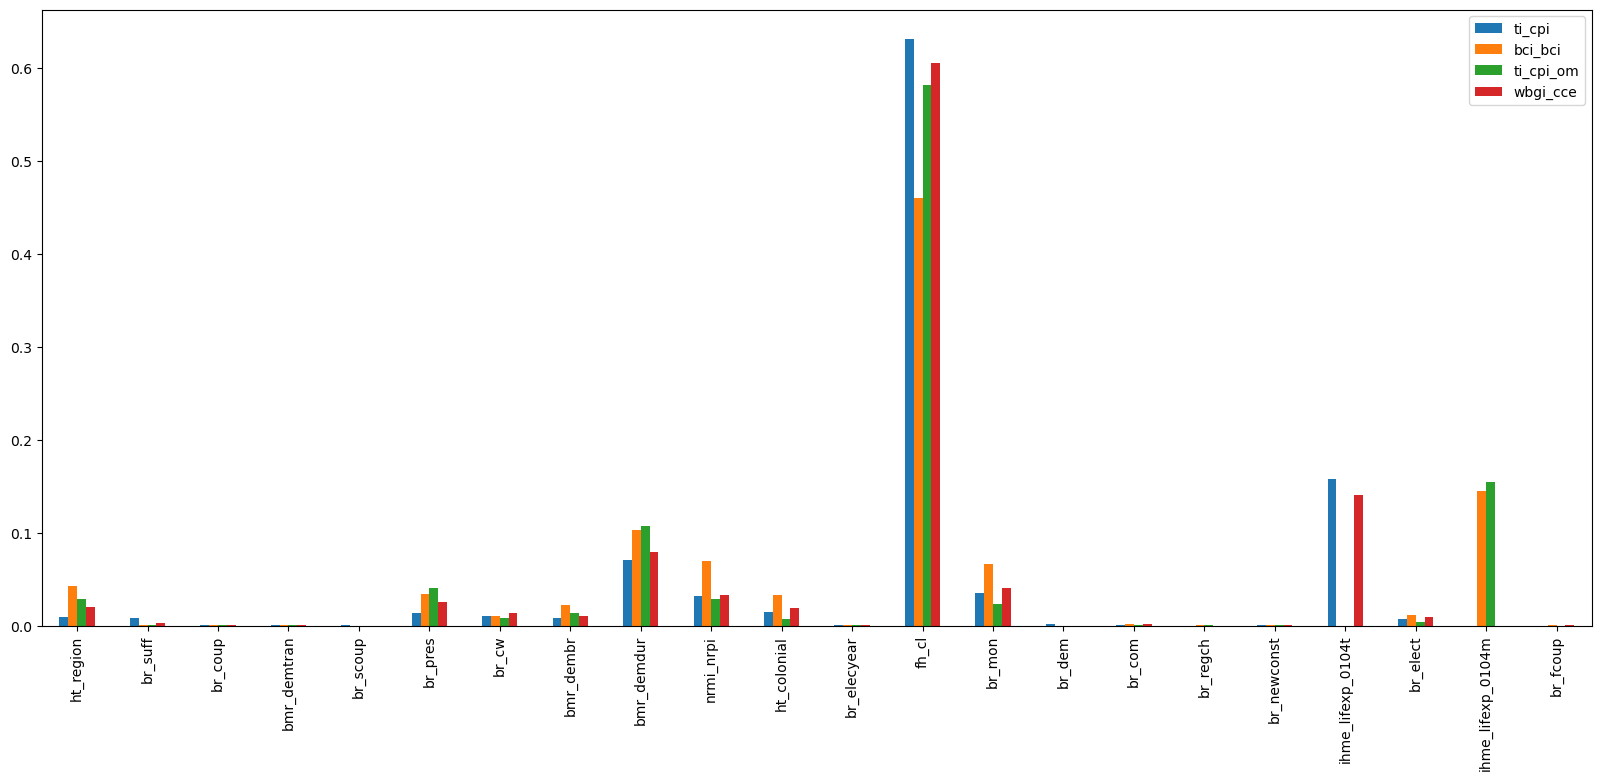

In [52]:
rf_info_script(selected_features_dict)

Next we use for all corruption indices the same set of features - the set of all as promising declared features.

scores


,r2,rmse
ti_cpi,0.711414,8.457733
bci_bci,0.297703,10.98921
ti_cpi_om,0.504587,1.221891
wbgi_cce,0.560194,0.556837


feature importance


,ihme_lifexp_0104m,ht_region,br_suff,ihme_hle_0104t,br_pres,br_cw,bmr_demdur,bmr_demfsuf,nrmi_nrpi,ihme_hle_0104m,...,fh_cl,fh_status,ihme_lifexp_0104f,br_mon,br_dem,fh_ipolity2,fh_pr,ihme_hle_0104f,ihme_lifexp_0104t,br_elect
ti_cpi,0.047017,0.005179,0.002085,0.029779,0.005212,0.007283,0.06905,0.000609,0.019464,0.023289,...,0.375115,0.00069,0.017182,0.033493,0.000562,0.102836,0.171229,0.026521,0.044315,0.005377
bci_bci,0.02548,0.021961,0.000051,0.041879,0.020717,0.005613,0.110685,0.001114,0.03965,0.04071,...,0.021633,0.001871,0.019534,0.075391,0.001278,0.449802,0.009998,0.024775,0.047245,0.010893
ti_cpi_om,0.026665,0.012207,0.001131,0.047635,0.007707,0.003347,0.112367,0.002175,0.016229,0.027289,...,0.02019,0.006373,0.018817,0.039974,0.000521,0.550352,0.013693,0.022818,0.063383,0.001104
wbgi_cce,0.0277,0.011199,0.00215,0.024753,0.017479,0.00617,0.085542,0.001641,0.025309,0.021498,...,0.024106,0.001081,0.015298,0.036341,0.000806,0.380512,0.24676,0.025945,0.026932,0.004441



feature importance rank


,ihme_lifexp_0104m,ht_region,br_suff,ihme_hle_0104t,br_pres,br_cw,bmr_demdur,bmr_demfsuf,nrmi_nrpi,ihme_hle_0104m,...,fh_cl,fh_status,ihme_lifexp_0104f,br_mon,br_dem,fh_ipolity2,fh_pr,ihme_hle_0104f,ihme_lifexp_0104t,br_elect
ti_cpi,5,17,18,8,16,14,4,20,11,10,...,1,19,12,7,21,3,2,9,6,15
bci_bci,9,11,22,5,13,17,2,21,7,6,...,12,18,14,3,19,1,16,10,4,15
ti_cpi_om,7,13,20,4,14,17,2,18,11,6,...,9,15,10,5,22,1,12,8,3,21
wbgi_cce,5,15,18,9,12,16,3,19,8,11,...,10,21,13,4,22,1,2,7,6,17


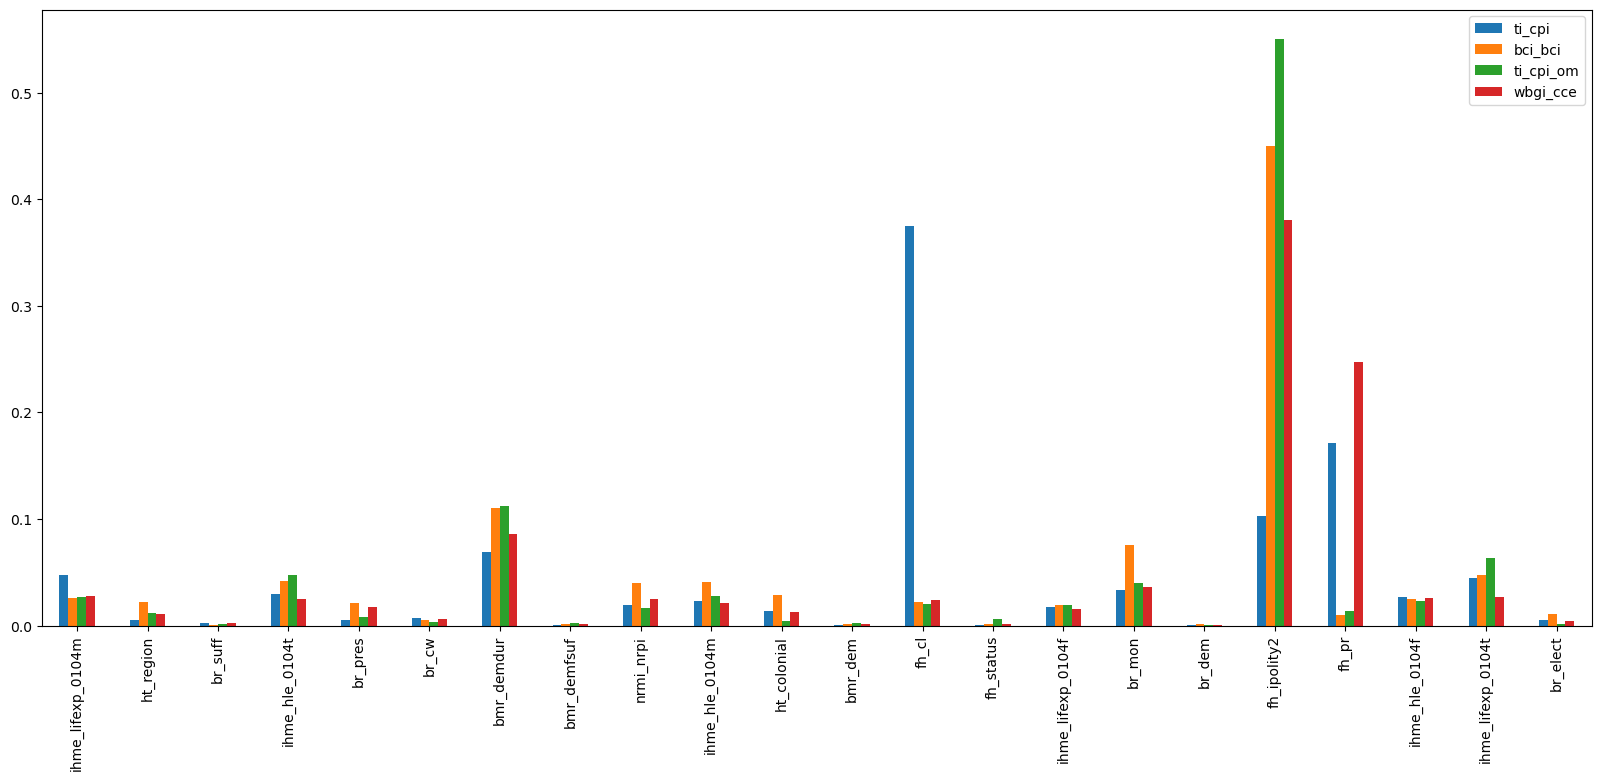

In [53]:
rf_info_script(best_features_union)

Now we use only the features that are in all individually selected feature sets.

scores


,r2,rmse
ti_cpi,0.345265,12.739396
bci_bci,0.358669,10.501394
ti_cpi_om,0.428999,1.311799
wbgi_cce,0.359988,0.671725


feature importance


,br_elecyear,br_regch,bmr_dembr,fh_cl,bmr_demdur,ht_region,br_mon,nrmi_nrpi,br_suff,br_coup,br_newconst,bmr_demtran,br_scoup,ht_colonial,br_pres,br_elect,br_cw,br_com
ti_cpi,0.001476,0.0,0.014424,0.65248,0.086984,0.017701,0.02898,0.063858,0.003573,0.000102,0.000219,0.00011,0.000065,0.040479,0.066228,0.012574,0.008394,0.002351
bci_bci,0.000978,0.000057,0.027665,0.479114,0.132383,0.046864,0.057247,0.108878,0.001825,0.00008,0.000214,0.000109,0.000024,0.047324,0.059161,0.022095,0.00891,0.007073
ti_cpi_om,0.001644,0.000056,0.020042,0.596623,0.138155,0.035942,0.022642,0.071572,0.001422,0.000093,0.000258,0.000053,0.000038,0.020238,0.078211,0.006512,0.005728,0.000771
wbgi_cce,0.000986,0.000066,0.016116,0.623025,0.097728,0.023556,0.034854,0.065298,0.003571,0.000142,0.000158,0.000066,0.000048,0.031539,0.083494,0.008093,0.005568,0.005692



feature importance rank


,br_elecyear,br_regch,bmr_dembr,fh_cl,bmr_demdur,ht_region,br_mon,nrmi_nrpi,br_suff,br_coup,br_newconst,bmr_demtran,br_scoup,ht_colonial,br_pres,br_elect,br_cw,br_com
ti_cpi,13,<NA>,8,1,2,7,6,4,11,16,14,15,17,5,3,9,10,12
bci_bci,13,17,8,1,2,7,5,3,12,16,14,15,18,6,4,9,10,11
ti_cpi_om,11,16,8,1,2,5,6,4,12,15,14,17,18,7,3,9,10,13
wbgi_cce,13,17,8,1,2,7,5,4,12,15,14,16,18,6,3,9,11,10


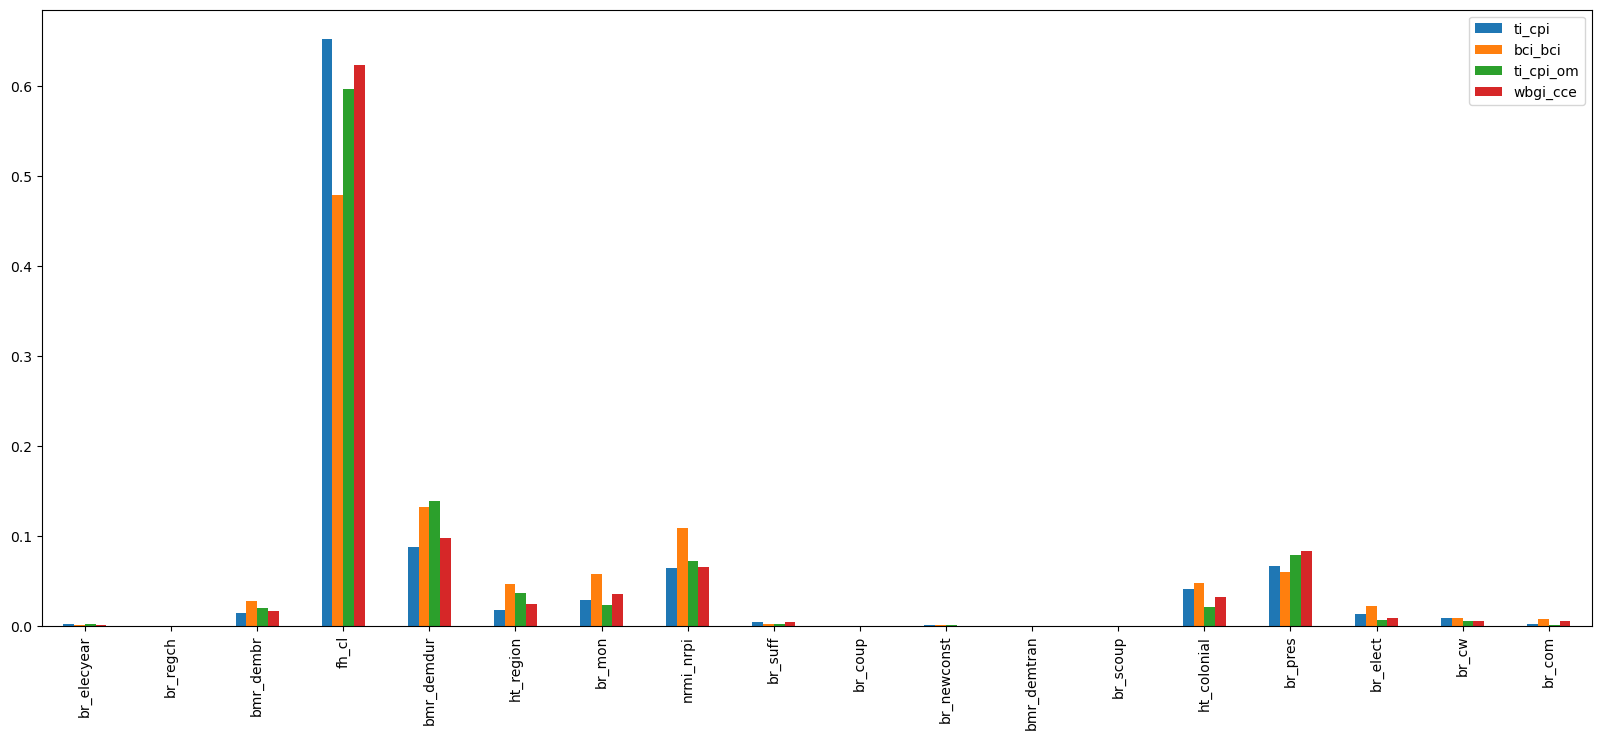

In [54]:
rf_info_script(selected_features_intersection)

The general picture of the results with Random Forest is not that different to the one with Lasso. Some differences are

- ti_cpi is predicted very well now both in comparison with Lasso and with all other indices
- HOWEVER, if only the minimal feature set is used ti_cpi is even worse than with Lasso
- for vdem_execorr the vdem_egal (Egalitarian component index) is the most important feature
- vdem_jucorr is now by far the most difficult to predict index
- although feature importance is not straight-forward comparable between Lasso (weight of coefficients) and Random Forest (Gini) it seems like Random Forst discriminates harder with regard to features

Random Forest performs either similarly or better for most setups / indices allthough no parameter optimization is done by now. So we continue with Random Forst and do hyperparameter optimization for some specific settings next to further optimize the results.

### Grid Search: Random Forest

With cross validation / hyperparameter grid search better parameters are determined. With those optimizations then again models are trained, then the test set is predicted and scores are evaluated.

The script defined below shows a similar report than above.

In [55]:
def rf_gridsearch_info_script(features):
    rf_bf = dict()

    param_grid = {
        "randomforestregressor__max_depth": [2, 3, 5, 10, None],
        "randomforestregressor__min_samples_split": [2, 3, 5, 10],
        "randomforestregressor__max_features": ["log2", None]
        }

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            rf_bf[target] = apply_gridsearch_rf(df, target, list(features[target]), param_grid, corr_cols, meta_cols, fprint=False)
        else:
            rf_bf[target] = apply_gridsearch_rf(df, target, features, param_grid, corr_cols, meta_cols, fprint=False)
        df_score.loc[target,] = [rf_bf[target]['r2'] ,rf_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    l_fi = [rf_bf[target]['feat_importance'] for target in corr_cols]
    df_fi = pd.concat(l_fi)
    rf_bf[target]
    l_firk = [rf_bf[target]['feat_importance_rank'] for target in corr_cols]
    df_firk = pd.concat(l_firk)
    rf_bf[target]['params']
    l_params = [rf_bf[target]['params'] for target in corr_cols]
    df_params = pd.concat(l_params)

    print('feature importance')
    display(df_fi)

    df_fi.T.plot(kind='bar', figsize=(20,8))
    print()

    print('feature importance rank')
    display(df_firk)
    print()

    print('params')
    display(df_params)
    print()


Now we only use for each index the individually selected feature set as we saw above that the results are comparable (so the feature selection process works adequately).

scores


,r2,rmse
ti_cpi,0.711747,8.45285
bci_bci,0.551642,8.780482
ti_cpi_om,0.623837,1.064723
wbgi_cce,0.636497,0.506234


feature importance


,ht_region,br_suff,br_coup,bmr_demtran,br_scoup,br_pres,br_cw,bmr_dembr,bmr_demdur,nrmi_nrpi,...,fh_cl,br_mon,br_dem,br_com,br_regch,br_newconst,ihme_lifexp_0104t,br_elect,ihme_lifexp_0104m,br_fcoup
ti_cpi,0.071784,0.00672,0.000838,0.000362,0.000046,0.042598,0.011688,0.015878,0.093171,0.05788,...,0.251815,0.070275,0.039357,0.004115,0.0,0.00009,0.238058,0.054516,NaN,NaN
bci_bci,0.087346,0.006889,0.001281,0.00016,0.000088,0.048495,0.008815,0.011199,0.094033,0.036161,...,0.280158,0.112819,NaN,0.002039,0.00001,0.000219,NaN,0.029291,0.239199,0.000627
ti_cpi_om,0.091003,0.001923,0.00083,0.00012,0.000018,0.042016,0.00514,0.008193,0.120626,0.033467,...,0.291454,0.065942,NaN,0.0015,0.000039,0.000553,NaN,0.032388,0.250332,0.000284
wbgi_cce,0.139155,0.004261,0.001079,0.000167,0.000049,0.034309,0.004701,0.008844,0.073207,0.031343,...,0.27599,0.0648,NaN,0.003536,0.000054,0.000274,0.274046,0.045278,NaN,0.000607



feature importance rank


,ht_region,br_suff,br_coup,bmr_demtran,br_scoup,br_pres,br_cw,bmr_dembr,bmr_demdur,nrmi_nrpi,...,fh_cl,br_mon,br_dem,br_com,br_regch,br_newconst,ihme_lifexp_0104t,br_elect,ihme_lifexp_0104m,br_fcoup
ti_cpi,4,13,16,17,19,8,12,11,3,6,...,1,5,9,14,<NA>,18,2,7,<NA>,<NA>
bci_bci,5,12,14,18,19,6,11,10,4,8,...,1,3,<NA>,13,20,17,<NA>,9,2,15
ti_cpi_om,4,12,14,18,20,7,11,10,3,8,...,1,5,<NA>,13,19,15,<NA>,9,2,17
wbgi_cce,3,12,14,18,20,8,11,10,4,9,...,1,5,<NA>,13,19,16,2,6,<NA>,15



params


,randomforestregressor__max_depth,randomforestregressor__max_features,randomforestregressor__min_samples_split
ti_cpi,10,log2,5
bci_bci,5,log2,10
ti_cpi_om,5,log2,5
wbgi_cce,5,log2,5


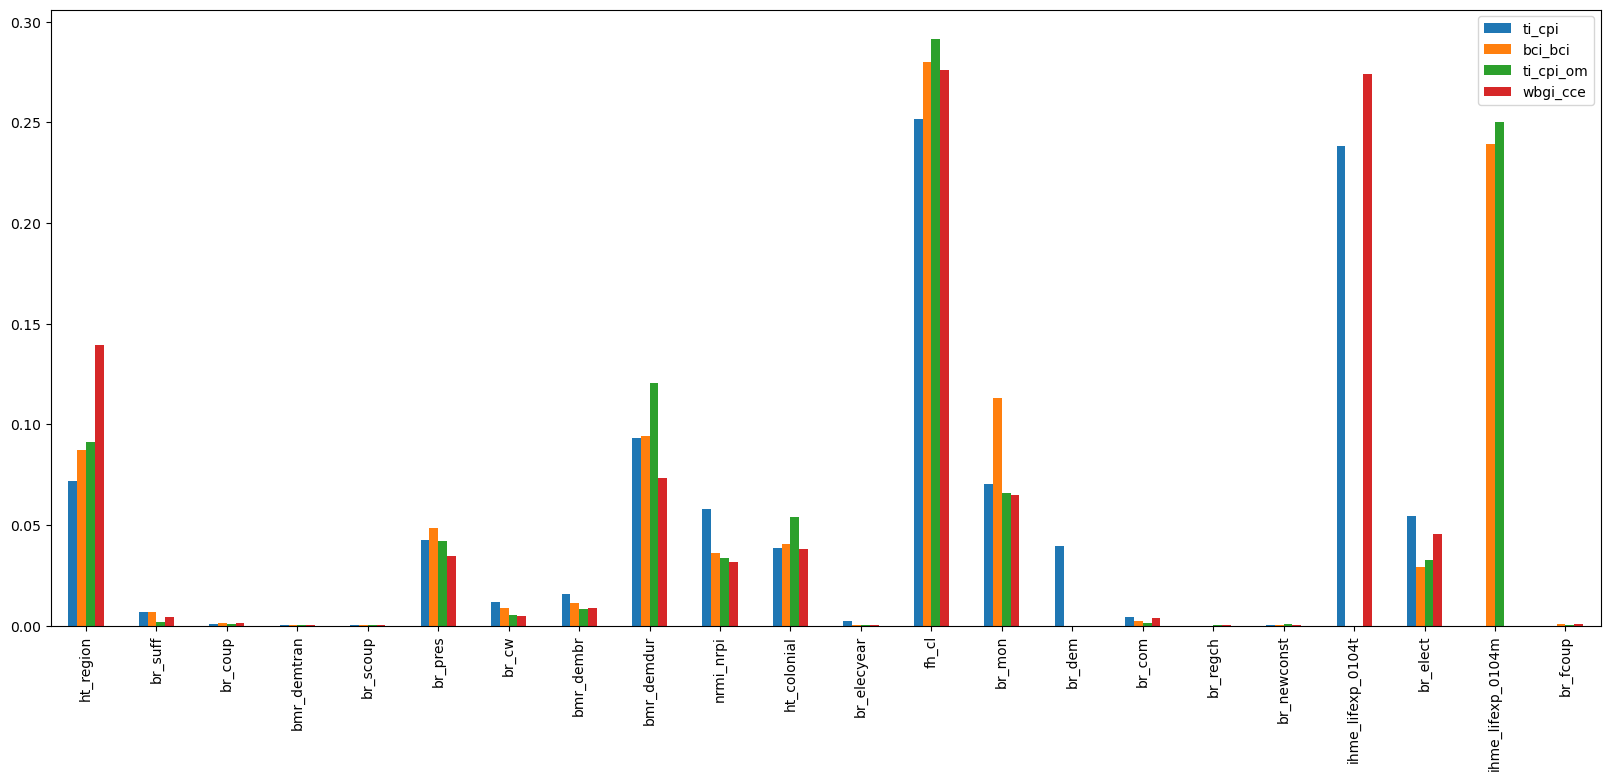

In [56]:
rf_gridsearch_info_script(selected_features_dict)

For most indices the hyperparameter optimization does not seem to significantly improve the r2-scores. But for vdem_jucorrdc it seems to improve. For vdem_pubcorr and wbgi_cce the improvement is minor.

The feature importance (figure) changes a lot more. Here we see for all but bci_bci that relatively wbgi_rle is not as important anymore. This is most likely due to the max_samples_features being log2 now. One could argue if the original model where wbgi_rle is the main feature is simpler and from the same quality or on the other side that other features are also able to replace wbgi_rle when combined.